# LASSO regression using grid search CV 


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

In [70]:
# Defining different measures to evaluate performance 
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

# SMAPE
def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

smape = make_scorer(symmetric_mape, 
                    greater_is_better=False)

def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [71]:
# Load in the time series
candy = pd.read_csv('dfV1.csv')
# Set the index equal to time stamp
candy.index = pd.to_datetime(candy["date"].apply(str)+' '+pd.to_datetime(candy["hour"], format = '%H').dt.time.apply(str))
# Drop old index, time stamp variable, hour variable, and values for DK2 and SYS
candy.drop(['date',"Unnamed: 0", "hour", "DK2", "SYS"], inplace=True, axis=1)

In [72]:
# Split the data into a train and test set
df_train, df_test = candy.iloc[:-10000], candy.iloc[-10000:]

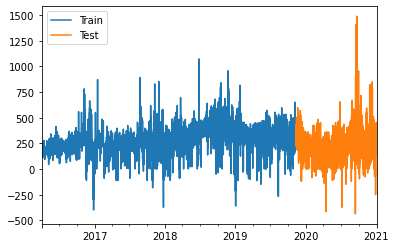

In [73]:
# Create plot visualizing the train and test data 

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test setsa dn show
df_train["DK1"].plot(ax=ax)
df_test["DK1"].plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
plt.show()

In [74]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK1"]].to_numpy()
y_test  = df_test[["DK1"]].to_numpy()

X_train = df_train.copy()
X_test  = df_test.copy()

X_train.drop('DK1', inplace=True, axis=1)
X_test.drop('DK1', inplace=True, axis=1)

X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()

In [75]:
# Define the pipeline for the Lasso regression
pipe_lasso = Pipeline([
                       ('scale', StandardScaler()),
                       ('lasso', Lasso())
                       ])

# Set the different values of lambdas to be searched through in the CV
params_lasso = {'lasso__alpha': np.logspace(-4,1,10)}

In [76]:
# Define the type of cross validation used in the grid search. The TimesSeriesSplit 
# is the k-fold alternative for times series keeping the natural order in the data 
# i.e. one avoid using future observations to predict the past. 
ts_cv = TimeSeriesSplit(n_splits=15).split(X_train)

# Define the pipeline for the grid search using the LASSO pipeline and defined type of CV.
# Further, we apply the relevant scoring and parallelizes the CV
gs_lasso = GridSearchCV(pipe_lasso,
                        param_grid=params_lasso,
                        scoring='neg_mean_absolute_error',
                        cv=ts_cv,
                        n_jobs=4)

In [77]:
ts_cv = TimeSeriesSplit(n_splits=15, test_size=1)
for train_index, test_index in ts_cv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)


TRAIN: [    0     1     2 ... 31618 31619 31620] TEST: [31621]
TRAIN: [    0     1     2 ... 31619 31620 31621] TEST: [31622]
TRAIN: [    0     1     2 ... 31620 31621 31622] TEST: [31623]
TRAIN: [    0     1     2 ... 31621 31622 31623] TEST: [31624]
TRAIN: [    0     1     2 ... 31622 31623 31624] TEST: [31625]
TRAIN: [    0     1     2 ... 31623 31624 31625] TEST: [31626]
TRAIN: [    0     1     2 ... 31624 31625 31626] TEST: [31627]
TRAIN: [    0     1     2 ... 31625 31626 31627] TEST: [31628]
TRAIN: [    0     1     2 ... 31626 31627 31628] TEST: [31629]
TRAIN: [    0     1     2 ... 31627 31628 31629] TEST: [31630]
TRAIN: [    0     1     2 ... 31628 31629 31630] TEST: [31631]
TRAIN: [    0     1     2 ... 31629 31630 31631] TEST: [31632]
TRAIN: [    0     1     2 ... 31630 31631 31632] TEST: [31633]
TRAIN: [    0     1     2 ... 31631 31632 31633] TEST: [31634]
TRAIN: [    0     1     2 ... 31632 31633 31634] TEST: [31635]


In [78]:
# Using the defined pipeline to fit our training set
gs_lasso.fit(X_train,y_train)
# And predicting using the LASSO regression model and the test data 
y_pred_lasso = gs_lasso.predict(X_test)

<ipython-input-79-d034d1ba64b8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = y_pred_lasso


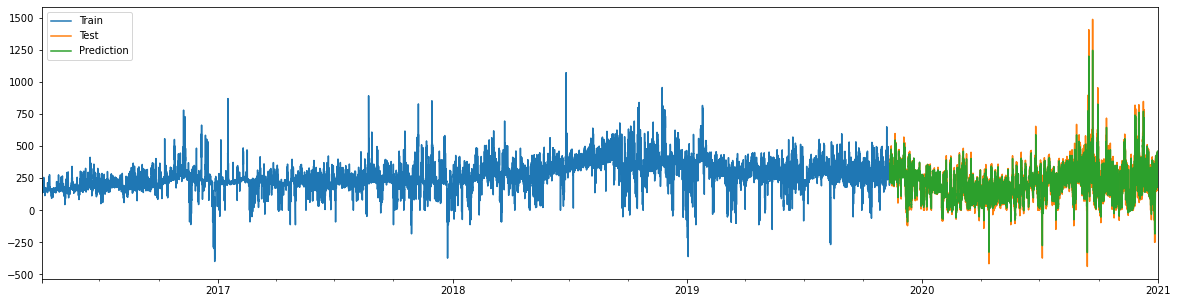

In [79]:
# Plot the actual values (train and test) and predicted valuesw
fig, ax = plt.subplots(figsize = (20,5))

df_train["DK1"].plot(ax=ax)
df_test["DK1"].plot(ax=ax)

df_test["pred"] = y_pred_lasso
df_test["pred"].plot(ax=ax)

ax.legend(["Train","Test","Prediction"]);
plt.show()

In [80]:
# Optimal lambda value from the grid search
print(f"Optimal lambda value using Lasso: {gs_lasso.best_params_}")

# Different scoring values
print_scores(y_test, y_pred_lasso)

Optimal lambda value using Lasso: {'lasso__alpha': 0.7742636826811278}
R2 score: 0.893134709501124
MSE score: 1792.442940291772
MAE score: 26.01291327539265
Median AE score: 16.114067476590833


<ipython-input-70-28dae6872f21>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAPE score: inf
SMAPE score: 38.656547976226726


In [81]:
# Defining the final pipeline using the optimal lambda detected from the grid search 
finalpipe_lasso = Pipeline([
                       ('scale', StandardScaler()),
                       ('lasso', Lasso(alpha = gs_lasso.best_params_["lasso__alpha"]))
                       ])

# Fitting the training data and predicting on the test data
finalpipe_lasso.fit(X_train,y_train)
finalpipe_lasso.predict(X_test)

array([366.31139165, 367.28966552, 360.13805789, ..., 407.76112464,
       379.23783838, 358.95764409])

In [82]:
# Save coefficients to a dictionary
candy.drop("DK1", inplace = True, axis = 1)
d = {}
for i in range(len(candy.columns)):
    d[candy.columns[i]] = list(finalpipe_lasso.named_steps['lasso'].coef_)[i]


In [83]:
d

{'DK1_CP': 7.2120761830440125,
 'DK2_CP': 0.0,
 'DK1_PP': 2.3358225414934326,
 'DK2_PP': 0.0,
 'DK1_WP': -10.662734618150953,
 'DK2_WP': -2.3083608779564737,
 'wind_max_per10min_past1h.L.1': 0.0,
 'temp_soil_max_past1h.L.1': 3.4040831209433726,
 'cloud_cover.L.1': -0.0,
 'bright_sunshine.L.1': 0.0,
 'mean_radiation.L.1': -0.2714833480508455,
 'mean_pressure.L.1': -0.0,
 'acc_precip.L.1': -0.0,
 'temp_grass.L.1': 0.0,
 'mean_relative_hum.L.1': -0.0,
 'mean_temp.L.1': 0.0,
 'mean_wind_speed.L.1': 0.6028440594682741,
 'mean_wind_dir.L.1': 0.0,
 'gold.L.1': -0.0,
 'silver.L.1': -0.25586872298378127,
 'crude-oil.L.1': 0.0,
 'rotterdam-coal-futures.L.1': 3.4827337832385847,
 'natural-gas.L.1': 0.37055210387602244,
 'carbon-emissions.L.1': 5.499385002128231,
 'DK net exchange.L.1': -5.9498889640840185,
 'DK1 net exchange.L.1': -0.0,
 'DK2 net exchange.L.1': -0.0,
 'DK - DE.L.1': -0.0,
 'DK - NO.L.1': -0.0,
 'DK - SE.L.1': -0.0,
 'DK1 - SE3.L.1': 0.0,
 'DK2 - SE4.L.1': -0.0,
 'DK1 - DE.L.1': -